In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, accuracy_score, roc_curve, roc_auc_score
import numpy as np
import keras
import matplotlib.pyplot as plt

In [2]:
SEQ_SIZE = 151

fontsize = 24
train_file_path = "train_data.csv"

df = pd.read_csv(train_file_path)
df = df.sample(frac = 1)

split_data = int(df.shape[0]*0.8)
train_data = df[:split_data]
test_data = df[split_data:]
train_labels = train_data.pop(train_data.columns[0])
train_labels_cat = to_categorical(train_labels, num_classes=2)
train_data = to_categorical(train_data.values.reshape(train_data.shape[0], SEQ_SIZE, 1), num_classes=4)
test_labels = test_data.pop(test_data.columns[0])
test_labels_cat = to_categorical(test_labels, num_classes=2)
test_data = to_categorical(test_data.values.reshape(test_data.shape[0], SEQ_SIZE, 1), num_classes=4)

In [3]:
def get_conv1d_layer(inpt, num_filts, filt_sz, activation = tf.nn.relu6, strides = 1, pad = 'same', ):
    conv_layer = tf.keras.layers.Conv1D(
        filters = num_filts, kernel_size = filt_sz, 
        strides = strides, kernel_regularizer='L1L2', 
        padding = pad, data_format='channels_last', use_bias=False)(inpt)
    batch_norm = tf.keras.layers.BatchNormalization(scale = False,)(conv_layer)
    return tf.keras.layers.Activation(activation)(batch_norm)

def get_compiled_model():
    
    relu_act = tf.keras.layers.Activation(tf.nn.relu6)

    def get_res_incep_block(inpt, pad = 'same', data_format = 'channels_last', use_bias = False, scale = 0.6):
        rel_act = relu_act(inpt)
        conv_0_1 = get_conv1d_layer(rel_act, 32, 1)
        conv_1_1 = get_conv1d_layer(rel_act, 32, 1)
        conv_2_1 = get_conv1d_layer(rel_act, 32, 1)
        conv_1_2 = get_conv1d_layer(conv_1_1, 32, 3)
        conv_2_2 = get_conv1d_layer(conv_2_1, 48, 3)
        conv_2_3 = get_conv1d_layer(conv_2_2, 64, 3)
        concat_conv = tf.keras.layers.Concatenate()([conv_0_1, conv_2_3, conv_1_2])
        filter_conv = get_conv1d_layer(concat_conv, 384, 1, activation = "linear")
#         final_add_layer = tf.keras.layers.Add()([rel_act, filter_conv])
        final_add_layer = tf.keras.layers.Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape = tf.keras.backend.int_shape(rel_act)[1:],
                      arguments={'scale': scale})([rel_act, filter_conv])
        batch_norm = tf.keras.layers.BatchNormalization()(final_add_layer)
        return relu_act(batch_norm)

    input_layer = tf.keras.layers.Input(batch_shape=(None, SEQ_SIZE, 4), name='input')
    conv1_layer = get_conv1d_layer(input_layer, 32, 1)
    conv2_layer = get_conv1d_layer(input_layer, 384, 1)

    incp_layer = get_res_incep_block(conv2_layer)
    for _ in range(0, 9):
        incp_layer = get_res_incep_block(incp_layer)

    out_pool = tf.keras.layers.GlobalAveragePooling1D()(incp_layer)
    out_dropout = tf.keras.layers.Dropout(0.6)(out_pool)
    hid_dense = tf.keras.layers.Dense(1024, activation = 'linear')(out_dropout)
    out_dense = tf.keras.layers.Dense(2, activation = 'softmax')(hid_dense)

    model = tf.keras.models.Model(inputs = input_layer, outputs = out_dense)
    model.compile(optimizer=tf.optimizers.Adam(0.001), loss = tf.losses.categorical_crossentropy, metrics=['accuracy'])
    model.summary()

    return model

model = get_compiled_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 151, 4)]     0           []                               
                                                                                                  
 conv1d_1 (Conv1D)              (None, 151, 384)     1536        ['input[0][0]']                  
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 151, 384)    1152        ['conv1d_1[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_2 (Activation)      (None, 151, 384)     0           ['batch_normalization_1[0][0]

                                                                                                  
 activation_9 (Activation)      (None, 151, 384)     0           ['batch_normalization_8[0][0]']  
                                                                                                  
 lambda (Lambda)                (None, 151, 384)     0           ['activation[0][0]',             
                                                                  'activation_9[0][0]']           
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 151, 384)    1536        ['lambda[0][0]']                 
 rmalization)                                                                                     
                                                                                                  
 conv1d_11 (Conv1D)             (None, 151, 32)      12288       ['activation[2][0]']             
          

 ormalization)                                                                                    
                                                                                                  
 activation_21 (Activation)     (None, 151, 48)      0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 151, 32)      0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv1d_16 (Conv1D)             (None, 151, 32)      12288       ['activation[4][0]']             
                                                                                                  
 conv1d_21 (Conv1D)             (None, 151, 64)      9216        ['activation_21[0][0]']          
                                                                                                  
 conv1d_19

                                                                                                  
 activation_27 (Activation)     (None, 151, 32)      0           ['batch_normalization_29[0][0]'] 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 151, 128)     0           ['activation_24[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'activation_27[0][0]']          
                                                                                                  
 conv1d_29 (Conv1D)             (None, 151, 384)     49152       ['concatenate_3[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 151, 384)    1152        ['conv1d_29[0][0]']              
 ormalizat

                                                                                                  
 activation_40 (Activation)     (None, 151, 32)      0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv1d_41 (Conv1D)             (None, 151, 48)      4608        ['activation_40[0][0]']          
                                                                                                  
 conv1d_38 (Conv1D)             (None, 151, 32)      12288       ['activation[10][0]']            
                                                                                                  
 batch_normalization_46 (BatchN  (None, 151, 48)     144         ['conv1d_41[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_nor

 ormalization)                                                                                    
                                                                                                  
 batch_normalization_55 (BatchN  (None, 151, 64)     192         ['conv1d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_53 (BatchN  (None, 151, 32)     96          ['conv1d_47[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_45 (Activation)     (None, 151, 32)      0           ['batch_normalization_50[0][0]'] 
                                                                                                  
 activatio

                                                                                                  
 lambda_7 (Lambda)              (None, 151, 384)     0           ['activation[14][0]',            
                                                                  'activation_58[0][0]']          
                                                                                                  
 batch_normalization_65 (BatchN  (None, 151, 384)    1536        ['lambda_7[0][0]']               
 ormalization)                                                                                    
                                                                                                  
 conv1d_60 (Conv1D)             (None, 151, 32)      12288       ['activation[16][0]']            
                                                                                                  
 batch_normalization_68 (BatchN  (None, 151, 32)     96          ['conv1d_60[0][0]']              
 ormalizat

 activation_70 (Activation)     (None, 151, 48)      0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_67 (Activation)     (None, 151, 32)      0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv1d_65 (Conv1D)             (None, 151, 32)      12288       ['activation[18][0]']            
                                                                                                  
 conv1d_70 (Conv1D)             (None, 151, 64)      9216        ['activation_70[0][0]']          
                                                                                                  
 conv1d_68 (Conv1D)             (None, 151, 32)      3072        ['activation_67[0][0]']          
                                                                                                  
 batch_nor

In [4]:
early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience = 4, verbose=1)
redonplat = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", mode="max", patience=3, verbose=2)
callbacks_list = [early, redonplat, tf.keras.callbacks.TensorBoard('logs')]

In [5]:
hist = model.fit(train_data, train_labels_cat, epochs=100, validation_split=0.20, batch_size=32, callbacks=callbacks_list, shuffle=True)

Epoch 1/100
679/679 [==============================] - 121s 140ms/step - loss: 0.5633 - accuracy: 0.7197 - val_loss: 0.4798 - val_accuracy: 0.7796 - lr: 0.0010
Epoch 2/100
679/679 [==============================] - 93s 136ms/step - loss: 0.4972 - accuracy: 0.7616 - val_loss: 0.4973 - val_accuracy: 0.7698 - lr: 0.0010
Epoch 3/100
679/679 [==============================] - 90s 133ms/step - loss: 0.4765 - accuracy: 0.7750 - val_loss: 0.4930 - val_accuracy: 0.7730 - lr: 0.0010
Epoch 4/100
679/679 [==============================] - ETA: 0s - loss: 0.4624 - accuracy: 0.7869
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
679/679 [==============================] - 92s 135ms/step - loss: 0.4624 - accuracy: 0.7869 - val_loss: 0.5409 - val_accuracy: 0.7590 - lr: 0.0010
Epoch 5/100
679/679 [==============================] - 90s 133ms/step - loss: 0.4107 - accuracy: 0.8159 - val_loss: 0.4221 - val_accuracy: 0.8091 - lr: 1.0000e-04
Epoch 6/100
679/679 [=================

In [6]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
accuracy = accuracy_score(test_labels, pred_test)
print("Testing Accuracy: ", accuracy)

Testing Accuracy:  0.7917219030785093


In [7]:
cf_m = tf.math.confusion_matrix(test_labels, pred_test, num_classes=2)
print(cf_m)

tf.Tensor(
[[2752  647]
 [ 767 2623]], shape=(2, 2), dtype=int32)


In [8]:
recall = precision_recall_fscore_support(test_labels, pred_test, average="binary")
print('Precision: {0:0.2f}'.format(recall[0]))
print('Recall: {0:1.2f}'.format(recall[1]))
print('F1-Score: {0:2.2f}'.format(recall[2]))

Precision: 0.80
Recall: 0.77
F1-Score: 0.79


In [9]:
pred_test = np.argmax(model.predict(test_data), axis = 1)
pred_test = to_categorical(pred_test)
ns_auc = roc_auc_score(test_labels_cat[:, 0], pred_test[:, 0])
lr_auc = roc_auc_score(test_labels_cat[:, 1], pred_test[:, 1])
print('Non-Promoter: ROC AUC=%.3f' % (ns_auc))
print('Promoter: ROC AUC=%.3f' % (lr_auc))
ns_fpr, ns_tpr, _ = roc_curve(test_labels_cat[:, 0], pred_test[:, 0])
lr_fpr, lr_tpr, _ = roc_curve(test_labels_cat[:, 1], pred_test[:, 1])

Non-Promoter: ROC AUC=0.792
Promoter: ROC AUC=0.792


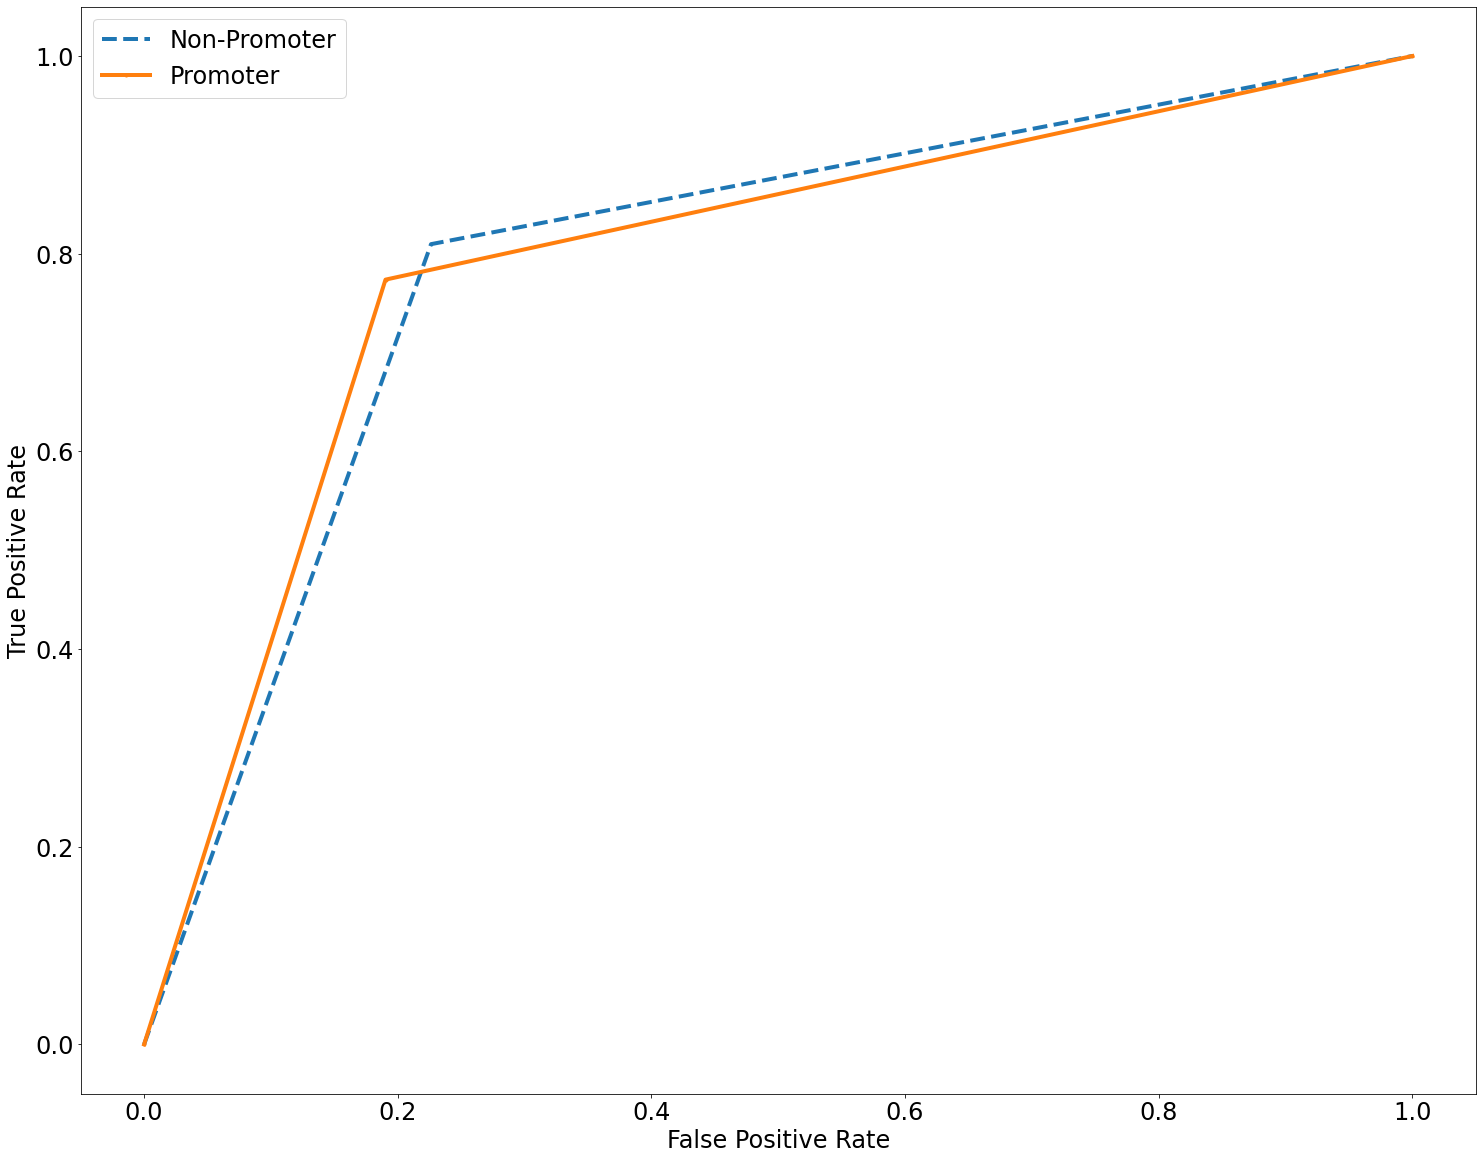

In [10]:
fig = plt.figure(figsize=(25, 20))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Non-Promoter', linewidth=4)
plt.plot(lr_fpr, lr_tpr, marker='.', label='Promoter', linewidth=4)
plt.xlabel('False Positive Rate', fontsize=fontsize)
plt.ylabel('True Positive Rate', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.savefig("roc_inception.png")

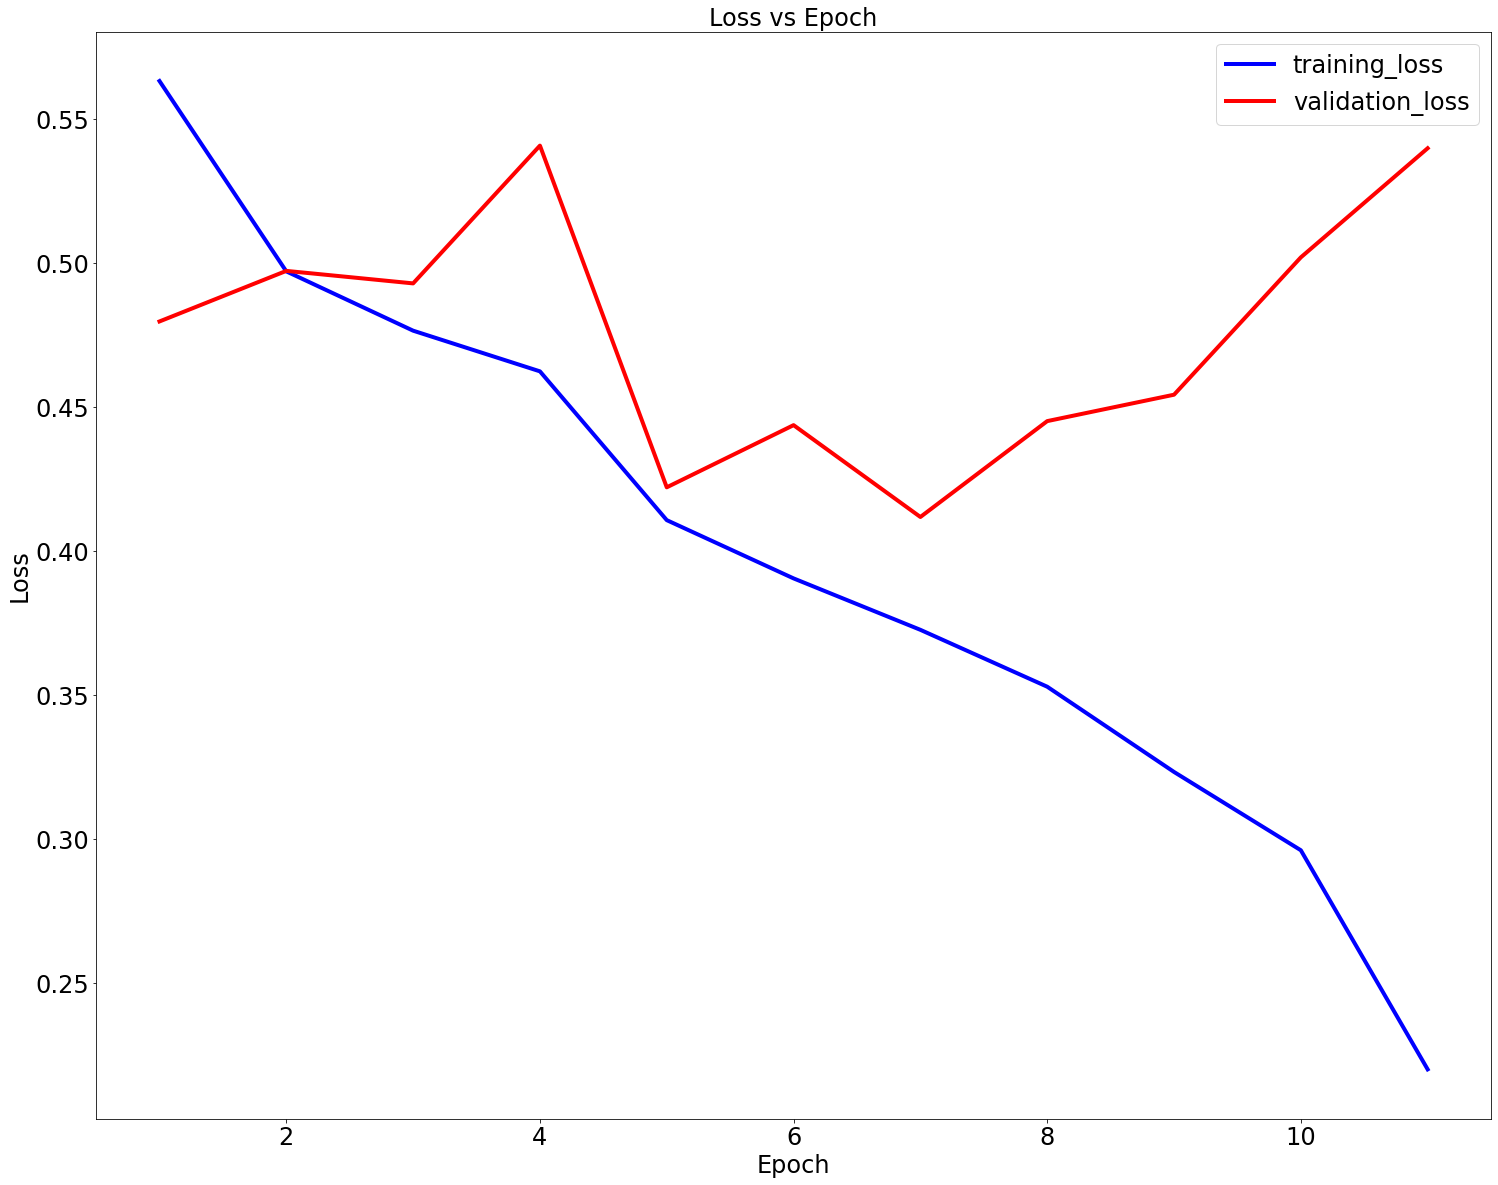

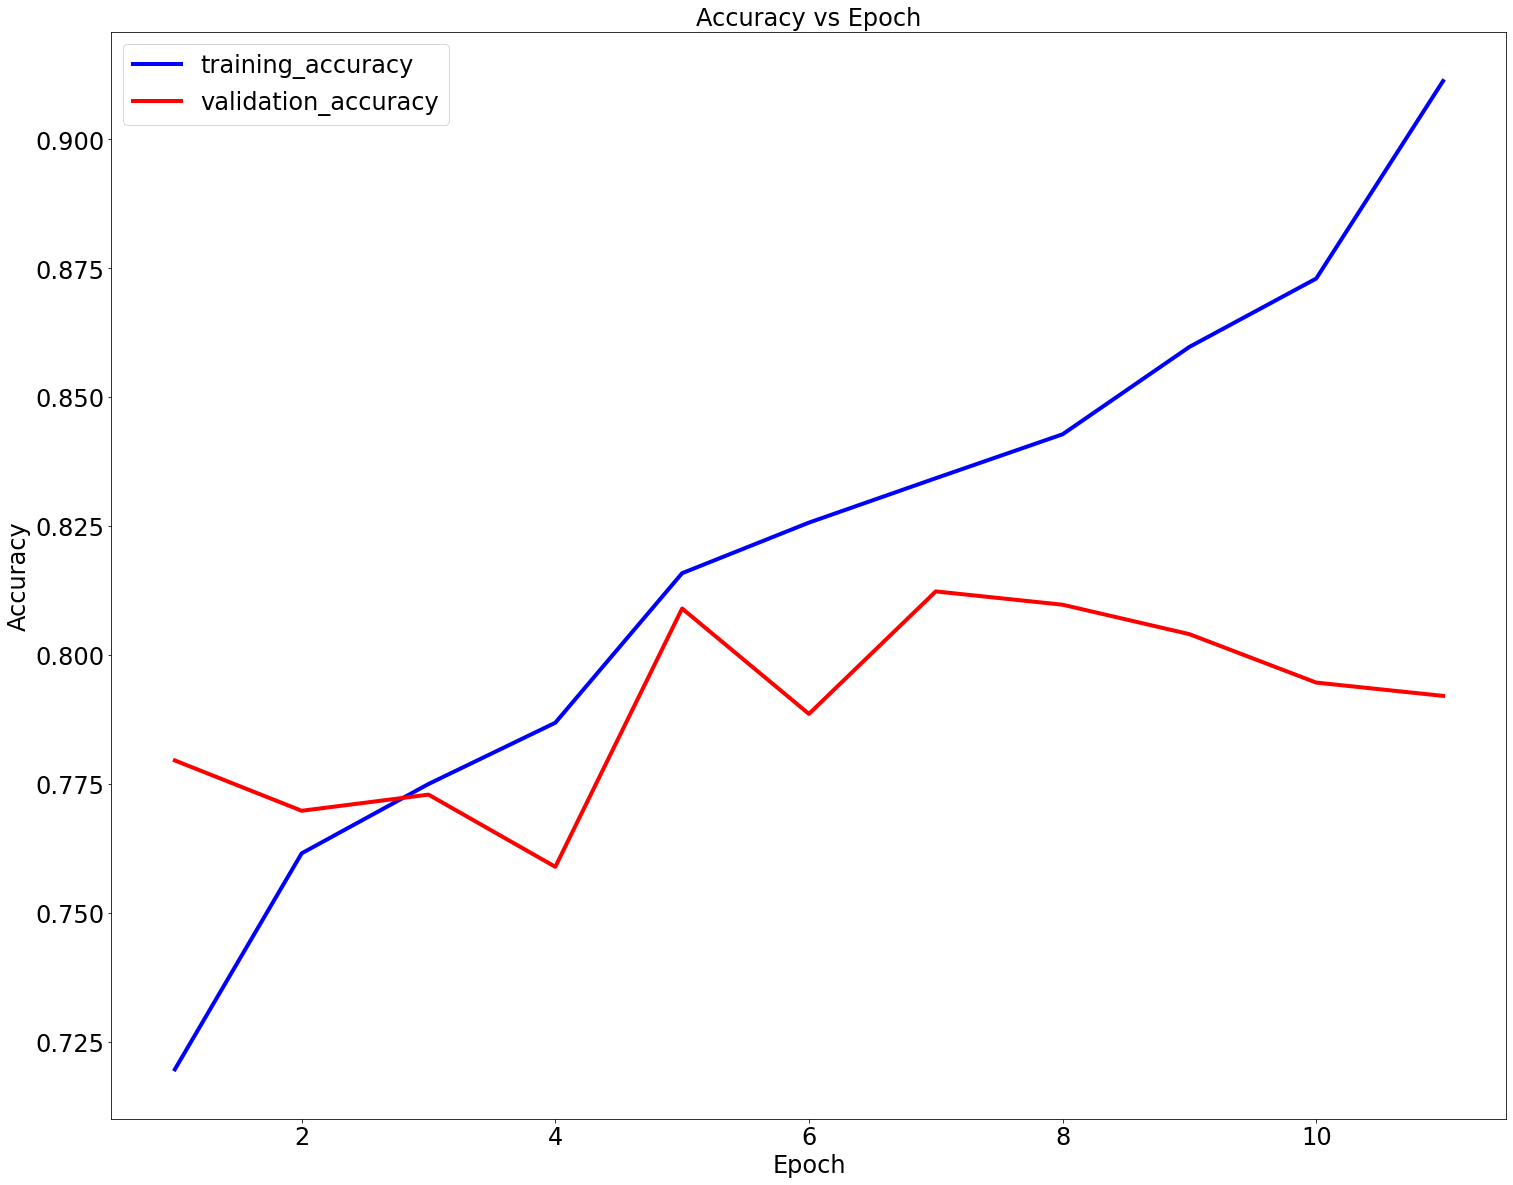

In [11]:
summ = hist.history

epochs = [i for i in range(1, len(summ['loss'])+1)]

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['loss'], color='blue', label="training_loss", linewidth=4)
plt.plot(epochs, summ['val_loss'], color='red', label="validation_loss", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Loss vs Epoch', fontsize=fontsize)
plt.ylabel('Loss', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
# plt.show()
plt.savefig("loss_inception.png")

fig = plt.figure(figsize=(25, 20))
plt.plot(epochs, summ['accuracy'], color='blue', label="training_accuracy", linewidth=4)
plt.plot(epochs, summ['val_accuracy'], color='red',label="validation_accuracy", linewidth=4)
plt.legend(loc='best', fontsize=fontsize)
plt.title('Accuracy vs Epoch', fontsize=fontsize)
plt.ylabel('Accuracy', fontsize=fontsize)
plt.xlabel('Epoch', fontsize=fontsize)
# plt.show()
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.savefig("accuracy_inception.png")